In [27]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import date, timedelta
import statistics

In [4]:
dataframe = pd.read_csv('big_data_added_columns.csv')
dataframe.head(20)

/var/folders/cw/hgq_4j310_x0341w_fpbn62m0000gp/T/ipykernel_9541/1048126044.py:1: DtypeWarning: Columns (23,24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv('big_data_added_columns.csv')


,ROW_NUM,USER_ID,INV_OPEN_DATE,INV_NUM_ACCOUNTS,INV_ACC_BAL,MONEY_ACCOUNT_OPEN_DATE,MONEY_ACCOUNT_STATUS,MONEY_FICO,MONEY_DATA_UPDATE_DATE,MONEY_TOTAL_BALANCE,...,date_of_creating_new_columns,days_with_invest,days_with_money,days_with_relay,days_with_loan,days_with_credit,first_product,second_product,xbuy_days,xbuy_date
0,1.0,20278993.0,2021-10-09,1.0,503.99,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,542.0,NaN,543.0,NaN,NaN,relay,invest,1.0,2021-10-09
1,1.0,20278996.0,2021-10-03,1.0,2712.45,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,548.0,NaN,NaN,NaN,NaN,invest,NaN,NaN,NaN
2,1.0,20278999.0,NaN,NaN,NaN,2021-10-03,Active,9003.0,2023-04-02,1.21,...,2023-04-04,NaN,548.0,NaN,NaN,NaN,money,NaN,NaN,NaN
3,1.0,20279000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,NaN,NaN,548.0,NaN,NaN,relay,NaN,NaN,NaN
4,1.0,20279001.0,2021-10-04,2.0,376.95,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,547.0,NaN,NaN,NaN,NaN,invest,NaN,NaN,NaN
5,1.0,20279005.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,NaN,NaN,NaN,547.0,NaN,loan,NaN,NaN,NaN
6,1.0,20279010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,NaN,NaN,NaN,547.0,NaN,loan,NaN,NaN,NaN
7,1.0,20279014.0,2021-10-03,1.0,1094.55,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,548.0,NaN,548.0,NaN,NaN,relay,invest,0.0,2021-10-03
8,1.0,20279020.0,2021-10-05,3.0,10343.57,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,546.0,NaN,NaN,NaN,NaN,invest,NaN,NaN,NaN
9,1.0,20279027.0,2021-10-03,1.0,3737.80,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,548.0,NaN,NaN,NaN,NaN,invest,NaN,NaN,NaN


In [23]:
dataframe['first_product'].value_counts()

relay     1912611
invest     503531
money      483923
loan       331784
credit      33898
Name: first_product, dtype: int64

In [63]:
dataframe['second_product'].value_counts()

money     431578
invest    393310
loan      144174
credit     48823
relay        654
Name: second_product, dtype: int64

# Models

In [16]:
def analyze_relay(product):
    df = dataframe[dataframe['first_product'] == 'relay']
    cols = list(df.columns[13:21]) # relay columns

    # identify the desired target product
    if(product == 'PL'):
        drop_columns = ['PL_ACTIVE_IND']
        #cols.append('REL_LOAN_SQS')
        df['response'] = (dataframe['second_product'] == 'loan')

    if(product == 'Money'):
        drop_columns = ['BANKING_ACTIVE_IND']
        #cols.append('REL_MON_SQS')
        df['response'] = (dataframe['second_product'] == 'money')

    cols.append('response') # response variable
    df = df[cols]
    df = df.drop(columns=drop_columns)
    df.fillna(False,inplace=True)

    #downsample the data to balance the response variable (uses_money) (majority are users that do not use money and only use 1 product)
    #df = analyze_relay('PL')
    # Separate majority class (uses_money = 0 and num_products = 1)
    data_majority = df[df['response'] == False]
    data_minority = df[df['response'] == True]

    # Downsample majority class
    data_majority_downsampled = resample(data_majority, 
                                        replace=False,    # sample without replacement
                                        n_samples=len(data_minority),     # to match minority class
                                        random_state=123) # reproducible results

    # Combine minority class with downsampled majority class
    data_downsampled = pd.concat([data_majority_downsampled, data_minority])

    ## model
    X_train, X_test, y_train, y_test = train_test_split(data_downsampled[data_downsampled.columns[:-1]], data_downsampled['response'], test_size=0.33, random_state=34)
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # make predictions
    y_pred = model.predict(X_test)

    # check the accuracy
    accuracy = "ACCURACY: "+str(accuracy_score(y_test, y_pred))

    # find coefficients
    coefs = pd.DataFrame(zip(X_train.columns, np.transpose(model.coef_)), columns=['features', 'coef']) 

    # normalizing
    for i in range(coefs.shape[0]):
        coefs.iloc[i, 1] = 100 * (math.exp(coefs.iloc[i, 1]) - 1)

    # psuedo r^2
    fitted_values = model.predict(X_train)
    r2 = "R2: "+str(np.corrcoef(y_train, fitted_values)[0][1])

    return coefs, accuracy, model, df, r2



In [28]:
pl = analyze_relay('PL')
print(pl[1], pl[4])
pl[0]

/var/folders/cw/hgq_4j310_x0341w_fpbn62m0000gp/T/ipykernel_9541/3357635002.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['response'] = (dataframe['second_product'] == 'loan')


ACCURACY: 0.8173124484748557 R2: 0.6443206848338948


,features,coef
0,RELAY_FICO,1.350866
1,SL_ACTIVE_IND,-53.396943
2,MORTGAGE_ACTIVE_IND,2.701812
3,BANKING_ACTIVE_IND,-81.615609
4,INVEST_ACTIVE_IND,-73.573612
5,CC_ACTIVE_IND,9.27414
6,CSM_ACTIVE_IND,-98.549239


potential issue with people being able to start relay tracking after they open the product of choice. so like they start tracking an additional product after they have already opened the app

In [7]:
# Display new class counts
data = pl[3]
data['response'].value_counts()

False    1783960
True      128651
Name: response, dtype: int64

In [107]:
money = analyze_relay('Money')
print(money[1], money[4])
money[0]

/var/folders/cw/hgq_4j310_x0341w_fpbn62m0000gp/T/ipykernel_9541/3357635002.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['response'] = (dataframe['second_product'] == 'money')


ACCURACY: 0.6498947463048836 R2: 0.30480510533557753


,features,coef
0,RELAY_FICO,0.262577
1,SL_ACTIVE_IND,-69.994315
2,PL_ACTIVE_IND,-73.455615
3,MORTGAGE_ACTIVE_IND,-10.99301
4,INVEST_ACTIVE_IND,106.0881
5,CC_ACTIVE_IND,44.990599
6,CSM_ACTIVE_IND,-52.173633


In [9]:
money[3]['response'].value_counts()

False    1508106
True      404505
Name: response, dtype: int64

In [24]:
dataframe.columns

Index(['ROW_NUM', 'USER_ID', 'INV_OPEN_DATE', 'INV_NUM_ACCOUNTS',
       'INV_ACC_BAL', 'MONEY_ACCOUNT_OPEN_DATE', 'MONEY_ACCOUNT_STATUS',
       'MONEY_FICO', 'MONEY_DATA_UPDATE_DATE', 'MONEY_TOTAL_BALANCE',
       'LAST_PAYMENT_DATE', 'ORIGINATION_DATE', 'PRINCIPAL', 'RELAY_FICO',
       'SL_ACTIVE_IND', 'PL_ACTIVE_IND', 'MORTGAGE_ACTIVE_IND',
       'BANKING_ACTIVE_IND', 'INVEST_ACTIVE_IND', 'CC_ACTIVE_IND',
       'CSM_ACTIVE_IND', 'ACTIVE', 'RELAY_OPEN_DATE',
       'ONBOARDING_SUCCESS_DATE', 'FIRST_TRANSACTION_DATE', 'CREDIT_LINE',
       'CURRENT_CYCLE_BEHAVIOR_SEGMENT', 'uses_invest', 'uses_money',
       'uses_relay', 'uses_loan', 'uses_credit', 'num_products',
       'date_of_creating_new_columns', 'days_with_invest', 'days_with_money',
       'days_with_relay', 'days_with_loan', 'days_with_credit',
       'first_product', 'second_product', 'xbuy_days', 'xbuy_date'],
      dtype='object')

# Crossbuy Visualizations

In [29]:
xbuy = dataframe[pd.isnull(dataframe['xbuy_days']) != True]
xbuy.head(30)

,ROW_NUM,USER_ID,INV_OPEN_DATE,INV_NUM_ACCOUNTS,INV_ACC_BAL,MONEY_ACCOUNT_OPEN_DATE,MONEY_ACCOUNT_STATUS,MONEY_FICO,MONEY_DATA_UPDATE_DATE,MONEY_TOTAL_BALANCE,...,date_of_creating_new_columns,days_with_invest,days_with_money,days_with_relay,days_with_loan,days_with_credit,first_product,second_product,xbuy_days,xbuy_date
0,1.0,20278993.0,2021-10-09,1.0,503.99,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,542.0,NaN,543.0,NaN,NaN,relay,invest,1.0,2021-10-09
7,1.0,20279014.0,2021-10-03,1.0,1094.55,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,548.0,NaN,548.0,NaN,NaN,relay,invest,0.0,2021-10-03
15,1.0,20279040.0,2021-10-03,2.0,317619.37,2021-10-11,Active,647.0,2023-04-02,0.29,...,2023-04-04,548.0,540.0,548.0,519.0,NaN,relay,invest,0.0,2021-10-03
16,1.0,20279045.0,2021-10-07,2.0,5458.79,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,544.0,NaN,545.0,NaN,NaN,relay,invest,1.0,2021-10-07
17,1.0,20279053.0,NaN,NaN,NaN,2021-11-17,Active,456.0,2023-04-02,0.90,...,2023-04-04,NaN,503.0,503.0,NaN,NaN,relay,money,0.0,2021-11-17
19,1.0,20279070.0,2021-10-03,4.0,5413.05,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,548.0,NaN,548.0,NaN,NaN,relay,invest,0.0,2021-10-03
20,1.0,20279076.0,2021-10-05,2.0,92795.29,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,546.0,NaN,546.0,NaN,NaN,relay,invest,0.0,2021-10-05
21,1.0,20279092.0,NaN,NaN,NaN,2022-02-06,Active,800.0,2023-04-02,50.00,...,2023-04-04,NaN,422.0,548.0,NaN,NaN,relay,money,126.0,2022-02-06
22,1.0,20279094.0,2021-10-26,2.0,6470.37,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,525.0,NaN,548.0,NaN,NaN,relay,invest,23.0,2021-10-26
23,1.0,20279096.0,NaN,NaN,NaN,2021-10-12,Active,NaN,2023-04-02,777.53,...,2023-04-04,NaN,539.0,548.0,265.0,NaN,relay,money,9.0,2021-10-12


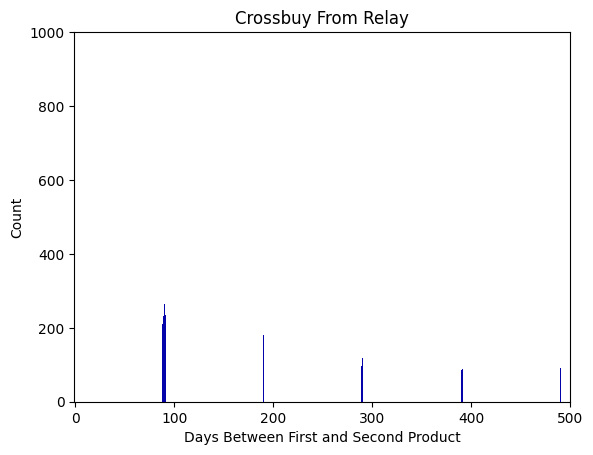

In [31]:
relay = xbuy[xbuy['first_product'] == 'relay']
plt.hist(x=relay['xbuy_days'], bins='auto', color='#0504aa')
plt.plot(axis='y')
plt.title('Crossbuy From Relay')
plt.xlabel('Days Between First and Second Product')
plt.ylabel('Count')
plt.xlim(left=-1, right=500)
plt.ylim(bottom=0, top=1000)
plt.show()

In [26]:
# select only the relay rows where crossbuy date is in the year 2022
relay = xbuy[(xbuy['xbuy_date'] >= '2022-01-01') & (xbuy['xbuy_date'] <= '2022-12-31')]
plt.hist(x=relay['xbuy_days'], bins='auto', color='#0504aa')
plt.plot(axis='y')
plt.title('Crossbuy From Relay')
plt.xlabel('Days Between First and Second Product')
plt.ylabel('Count')
plt.xlim(left=0, right=2000)
plt.show()

NameError: name 'xbuy' is not defined

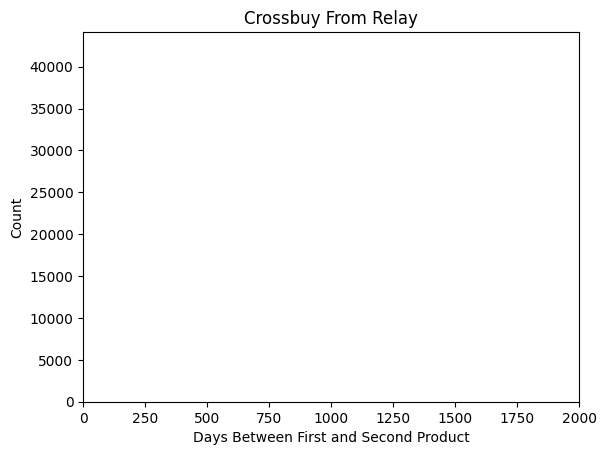

In [60]:
# make different dataframes for each year of xbuy_date where relay is the first product
relay_2021 = relay[(relay['xbuy_date'] >= '2021-01-01') & (relay['xbuy_date'] <= '2021-12-31')]
relay_2022 = relay[(relay['xbuy_date'] >= '2022-01-01') & (relay['xbuy_date'] <= '2022-12-31')]
relay_2023 = relay[(relay['xbuy_date'] >= '2023-01-01') & (relay['xbuy_date'] <= '2023-12-31')]
relay_2020 = relay[(relay['xbuy_date'] >= '2020-01-01') & (relay['xbuy_date'] <= '2020-12-31')]
relay_2019 = relay[(relay['xbuy_date'] >= '2019-01-01') & (relay['xbuy_date'] <= '2019-12-31')]
relay_2018 = relay[(relay['xbuy_date'] >= '2018-01-01') & (relay['xbuy_date'] <= '2018-12-31')]

# make a plot for each year where xbuy_date is the x and xbuy_days is the y
plt.hist(x=relay_2019['xbuy_days'], bins='auto', color='#0504aa')
plt.plot(axis='y')
plt.title('Crossbuy From Relay')
plt.xlabel('Days Between First and Second Product')
plt.ylabel('Count')
plt.xlim(left=0, right=2000)
plt.show()

In [82]:
with_xbuy = dataframe[(dataframe['first_product'] == 'relay') & (dataframe['second_product'].isnull() == False)]
no_xbuy = dataframe[(dataframe['first_product'] == 'relay') & (dataframe['second_product'].isnull())]

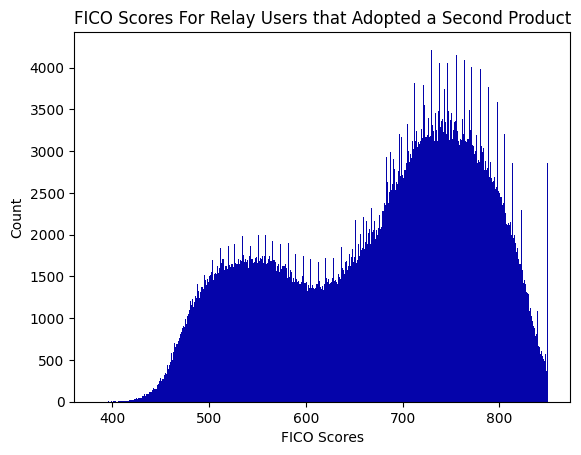

In [105]:
plt.hist(x=with_xbuy['RELAY_FICO'], bins=466, color='#0504aa')
plt.title('FICO Scores For Relay Users that Adopted a Second Product')
plt.xlabel('FICO Scores')
plt.ylabel('Count')
plt.show()

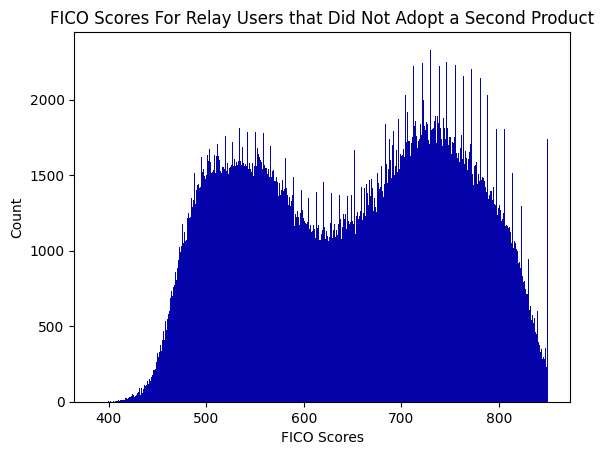

In [106]:
plt.hist(x=no_xbuy['RELAY_FICO'], bins=462, color='#0504aa')
plt.title('FICO Scores For Relay Users that Did Not Adopt a Second Product')
plt.xlabel('FICO Scores')
plt.ylabel('Count')
plt.show()

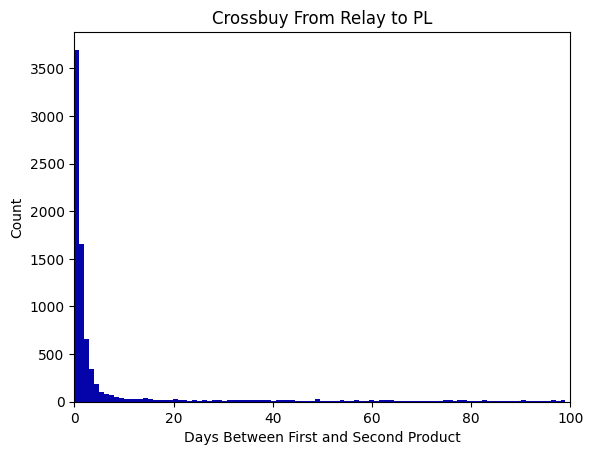

In [128]:
relay_pl = xbuy[xbuy['first_product'] == 'relay']
relay_pl = relay_pl[relay_pl['second_product'] == 'loan']
relay_pl = relay_pl[relay_pl['xbuy_days'] < 100]
plt.hist(x=relay_pl['xbuy_days'], bins=100, color='#0504aa')
plt.plot(axis='y')
plt.title('Crossbuy From Relay to PL')
plt.xlabel('Days Between First and Second Product')
plt.ylabel('Count')
plt.xlim(left=0, right=100)
plt.show()

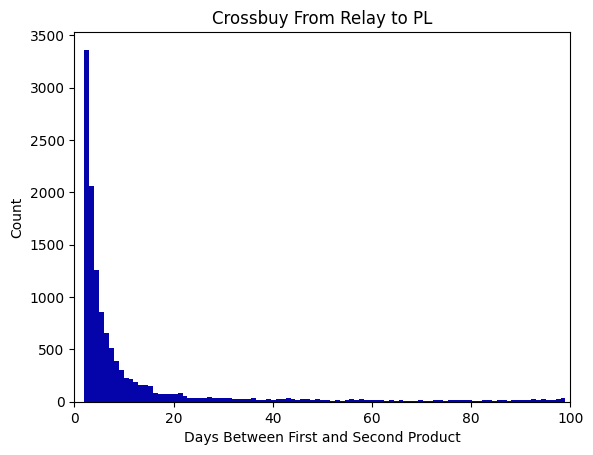

In [130]:
relay_pl = xbuy[xbuy['first_product'] == 'relay']
relay_pl =  relay_pl[relay_pl['second_product'] == 'loan']
relay_pl = relay_pl[(relay_pl['xbuy_days'] > 1) & (relay_pl['xbuy_days'] < 100)]
plt.hist(x=relay_pl['xbuy_days'], bins=98, color='#0504aa')
plt.plot(axis='y')
plt.title('Crossbuy From Relay to PL')
plt.xlabel('Days Between First and Second Product')
plt.ylabel('Count')
plt.xlim(left=0, right=100)
plt.show()

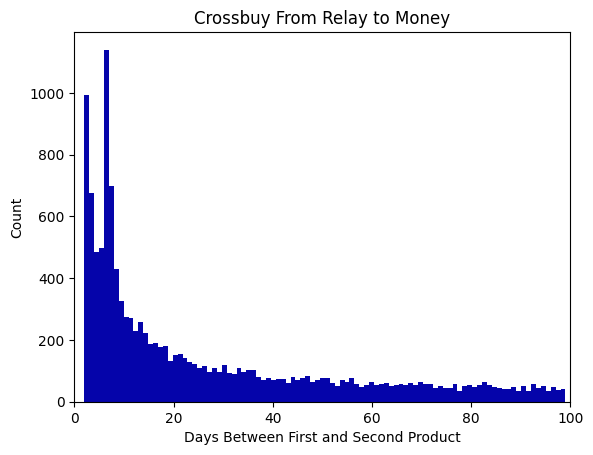

In [133]:
relay_money = xbuy[xbuy['first_product'] != 'relay']
relay_money = relay_money[relay_money['second_product'] == 'money']
relay_money = relay_money[(relay_money['xbuy_days'] > 1) & (relay_money['xbuy_days'] < 100)]
plt.hist(x=relay_money['xbuy_days'], bins=98, color='#0504aa')
plt.plot(axis='y')
plt.title('Crossbuy From Relay to Money')
plt.xlabel('Days Between First and Second Product')
plt.ylabel('Count')
plt.xlim(left=0, right=100)
plt.show()

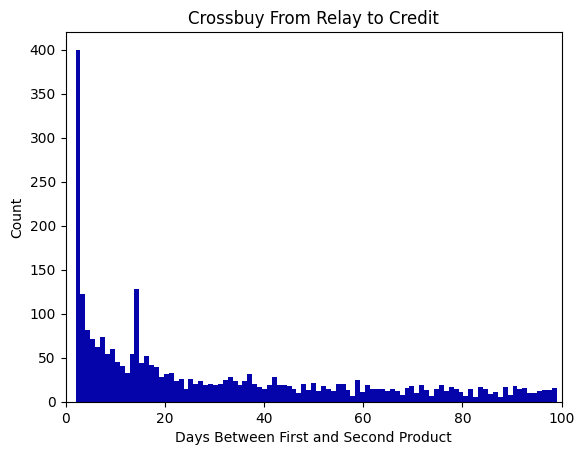

In [77]:
relay_credit = xbuy[xbuy['first_product'] == 'relay']
relay_credit = relay_credit[relay_credit['second_product'] == 'credit']
relay_credit = relay_credit[(relay_credit['xbuy_days'] > 1) & (relay_credit['xbuy_days'] < 100)]
plt.hist(x=relay_credit['xbuy_days'], bins=98, color='#0504aa')
plt.plot(axis='y')
plt.title('Crossbuy From Relay to Credit')
plt.xlabel('Days Between First and Second Product')
plt.ylabel('Count')
plt.xlim(left=0, right=100)
plt.show()

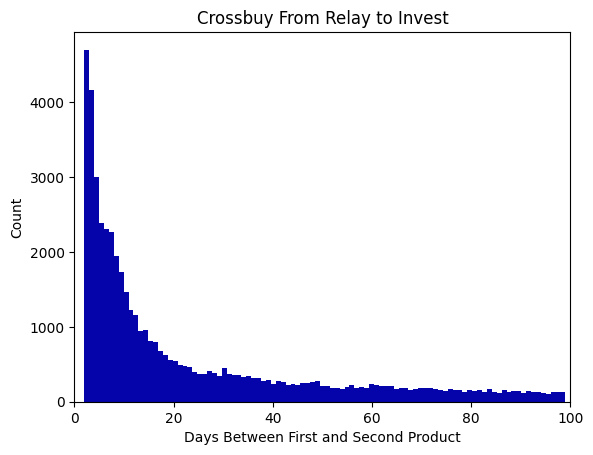

In [78]:
relay_invest = xbuy[xbuy['first_product'] == 'relay']
relay_invest = relay_invest[relay_invest['second_product'] == 'invest']
relay_invest = relay_invest[(relay_invest['xbuy_days'] > 1) & (relay_invest['xbuy_days'] < 100)]
plt.hist(x=relay_invest['xbuy_days'], bins=98, color='#0504aa')
plt.plot(axis='y')
plt.title('Crossbuy From Relay to Invest')
plt.xlabel('Days Between First and Second Product')
plt.ylabel('Count')
plt.xlim(left=0, right=100)
plt.show()

In [21]:
statistics.median(relay_pl['xbuy_days'])

0.0

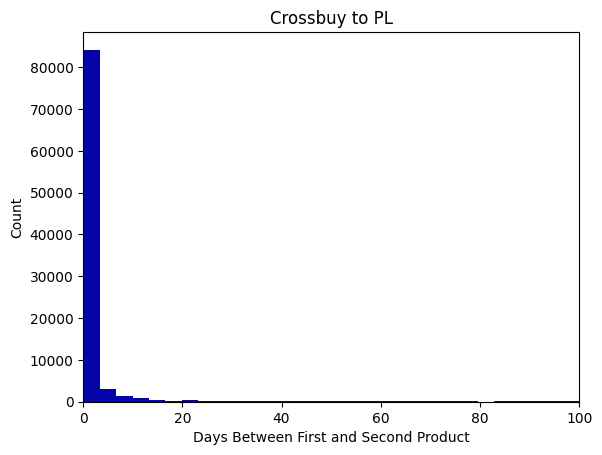

In [32]:
pl_second = xbuy[xbuy['second_product'] == 'loan']
plt.hist(x=pl_second['xbuy_days'], bins=1000, color='#0504aa')
plt.plot(axis='y')
plt.title('Crossbuy to PL')
plt.xlabel('Days Between First and Second Product')
plt.ylabel('Count')
plt.xlim(left=0, right=100)
plt.show()

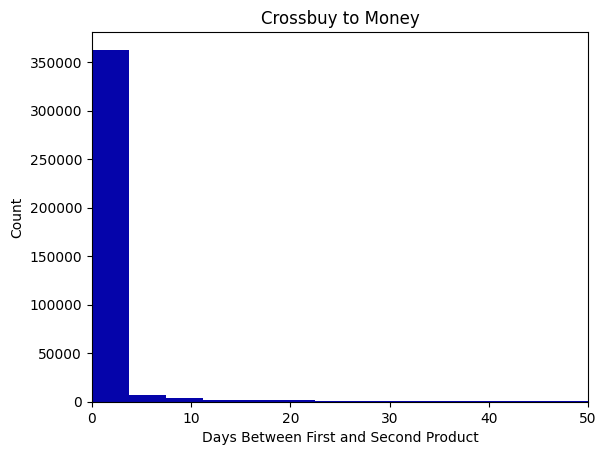

In [30]:
money_second = xbuy[xbuy['second_product'] == 'money']
plt.hist(x=money_second['xbuy_days'], bins=1000, color='#0504aa')
plt.plot(axis='y')
plt.title('Crossbuy to Money')
plt.xlabel('Days Between First and Second Product')
plt.ylabel('Count')
plt.xlim(left=0, right=50)
plt.show()

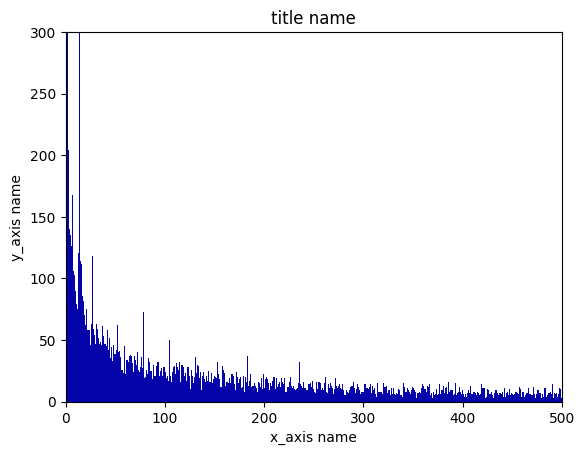

In [30]:
credit_second = xbuy[xbuy['second_product'] == 'credit']
plt.hist(x=credit_second['xbuy_days'], bins='auto', color='#0504aa')
plt.plot(axis='y')
plt.title('title name')
plt.xlabel('x_axis name')
plt.ylabel('y_axis name')
plt.xlim(left=0, right=500)
plt.ylim(bottom=0, top=300)
plt.show()

In [116]:
def get_xbuy_date(row):
    #gets the date the second product was adopted.
    if type(row['first_product']) == float:
        return None
    
    if row['first_product'] == 'relay':
        return row['RELAY_OPEN_DATE']
    elif row['first_product'] == 'money':
        return row['MONEY_ACCOUNT_OPEN_DATE']
    elif row['first_product'] == 'invest':
        return row['INV_OPEN_DATE']
    elif row['first_product'] == 'loan':
        return row['ORIGINATION_DATE']
    elif row['first_product'] == 'credit':
        return row['ONBOARDING_SUCCESS_DATE']

    
tqdm.pandas()
dataframe['first_prod_day'] = dataframe.progress_apply(get_xbuy_date, axis=1)

100%|██████████| 3266036/3266036 [00:49<00:00, 65539.25it/s]


In [117]:
dataframe.head()

,ROW_NUM,USER_ID,INV_OPEN_DATE,INV_NUM_ACCOUNTS,INV_ACC_BAL,MONEY_ACCOUNT_OPEN_DATE,MONEY_ACCOUNT_STATUS,MONEY_FICO,MONEY_DATA_UPDATE_DATE,MONEY_TOTAL_BALANCE,...,days_with_invest,days_with_money,days_with_relay,days_with_loan,days_with_credit,first_product,second_product,xbuy_days,xbuy_date,first_prod_day
0,1.0,20278993.0,2021-10-09,1.0,503.99,NaN,NaN,NaN,NaN,NaN,...,542.0,NaN,543.0,NaN,NaN,relay,invest,1.0,2021-10-09,2021-10-08
1,1.0,20278996.0,2021-10-03,1.0,2712.45,NaN,NaN,NaN,NaN,NaN,...,548.0,NaN,NaN,NaN,NaN,invest,NaN,NaN,NaN,2021-10-03
2,1.0,20278999.0,NaN,NaN,NaN,2021-10-03,Active,9003.0,2023-04-02,1.21,...,NaN,548.0,NaN,NaN,NaN,money,NaN,NaN,NaN,2021-10-03
3,1.0,20279000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,548.0,NaN,NaN,relay,NaN,NaN,NaN,2021-10-03
4,1.0,20279001.0,2021-10-04,2.0,376.95,NaN,NaN,NaN,NaN,NaN,...,547.0,NaN,NaN,NaN,NaN,invest,NaN,NaN,NaN,2021-10-04
